##**About the dataset**

###Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera


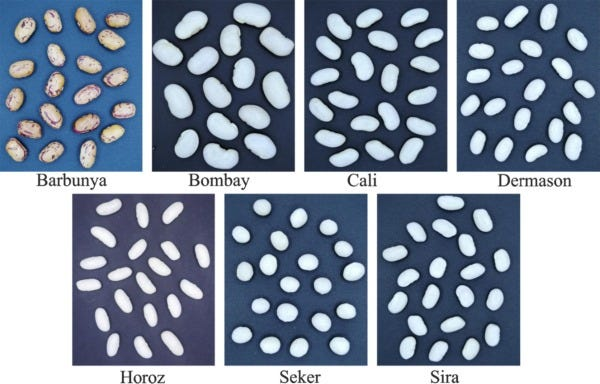

In [202]:
!pip install imbalanced-learn

In [203]:
# Necessary imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

##**Exploratory data analysis**

In [204]:
df = pd.read_excel("Dry_Bean_Dataset.xlsx")

In [205]:
df.head(5)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [206]:
df.shape

(13611, 17)

In [207]:
df.isna().sum()

# Lucky for us, there are no missing values in the dataset

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

In [208]:
# Checking for duplicates, as duplicates can lead to inaccurate analyses, biased models, and inefficient resource use

df.duplicated().any()

True

**Categorical data**

In [209]:
# Our target column is "Class", and it is the only categorical column

target = "Class"
value_counts = df[target].value_counts().sort_values(ascending=False)
value_counts

# It is visible that the most numerous bean type is DERMASON, and the least numerous is BOMBAY

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

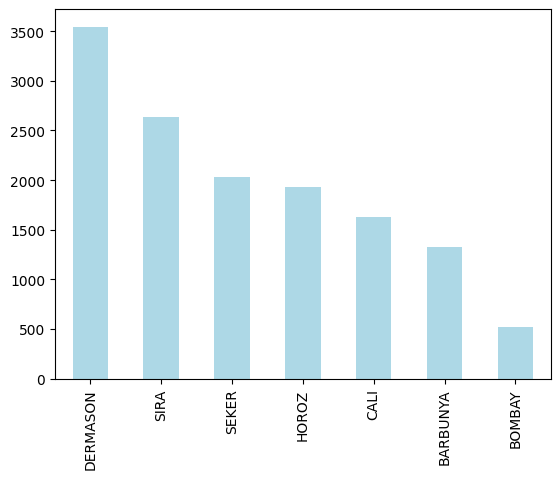

In [210]:
# Let's visualize the target values

value_counts.plot(kind='bar', color='lightblue')
plt.show()

### It is visible, that our target variable is imbalanced.

**Numerical data**

In [211]:
# Accessing features
features = df.columns[df.columns != target].tolist()
df[features].describe()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


###Looking at this table, we can notice that our data will need standardization in further steps, because our feature values exhibit significant differences in scale. **Standardization ensures that features contribute to the model in a comparable manner**

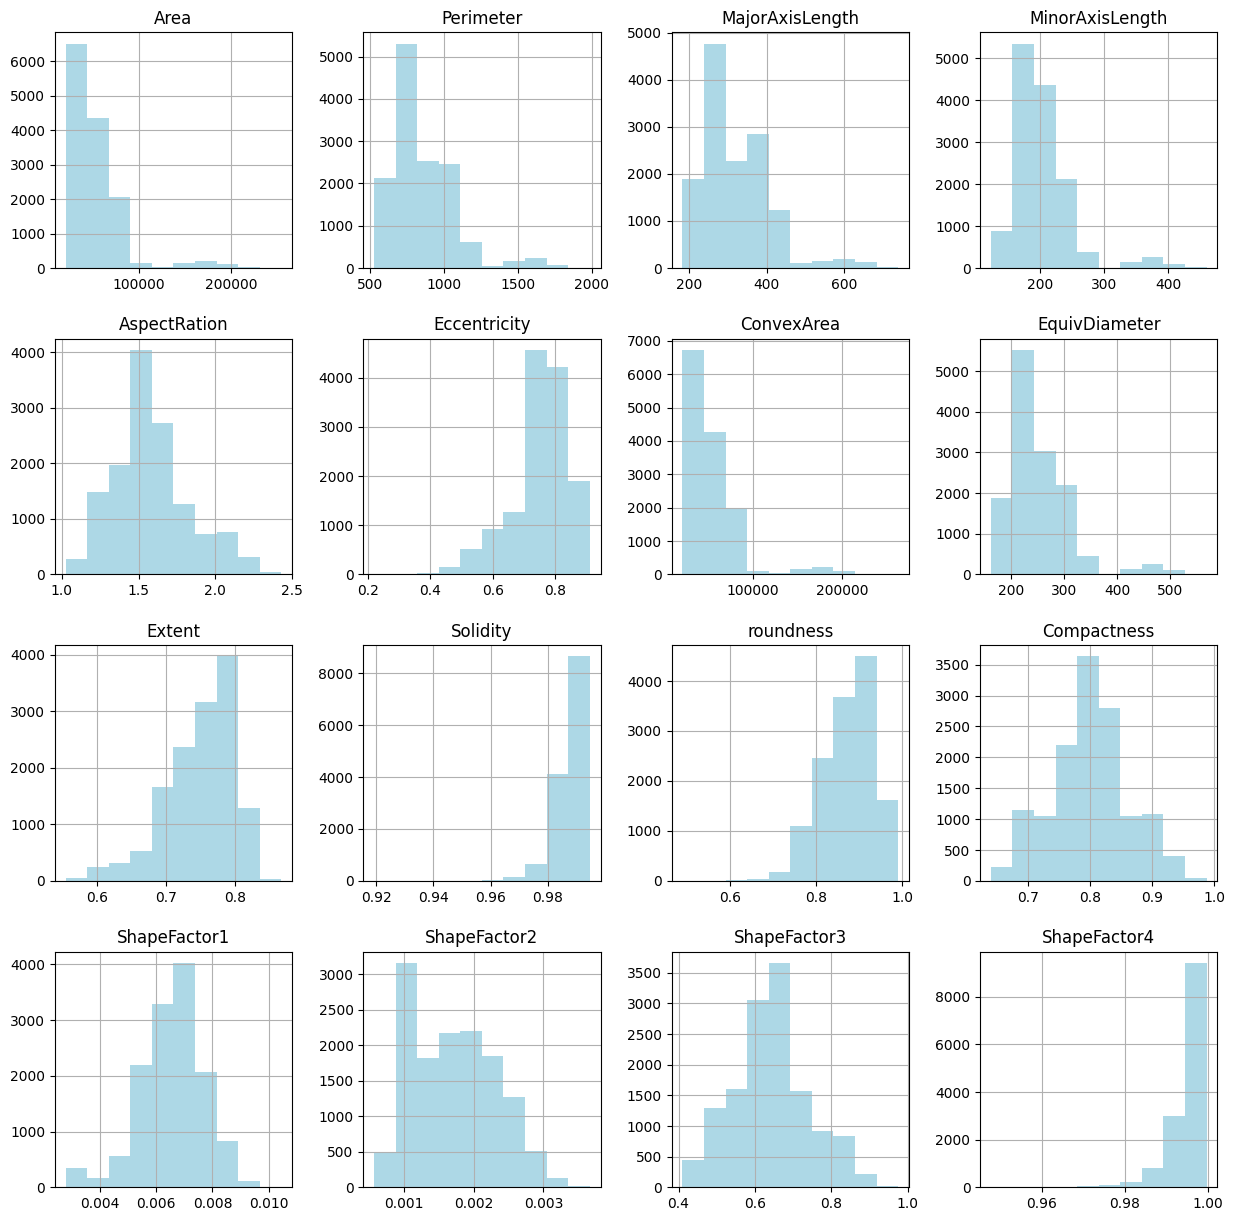

In [212]:
df[features].hist(figsize=(15, 15), color='lightblue')
plt.show()

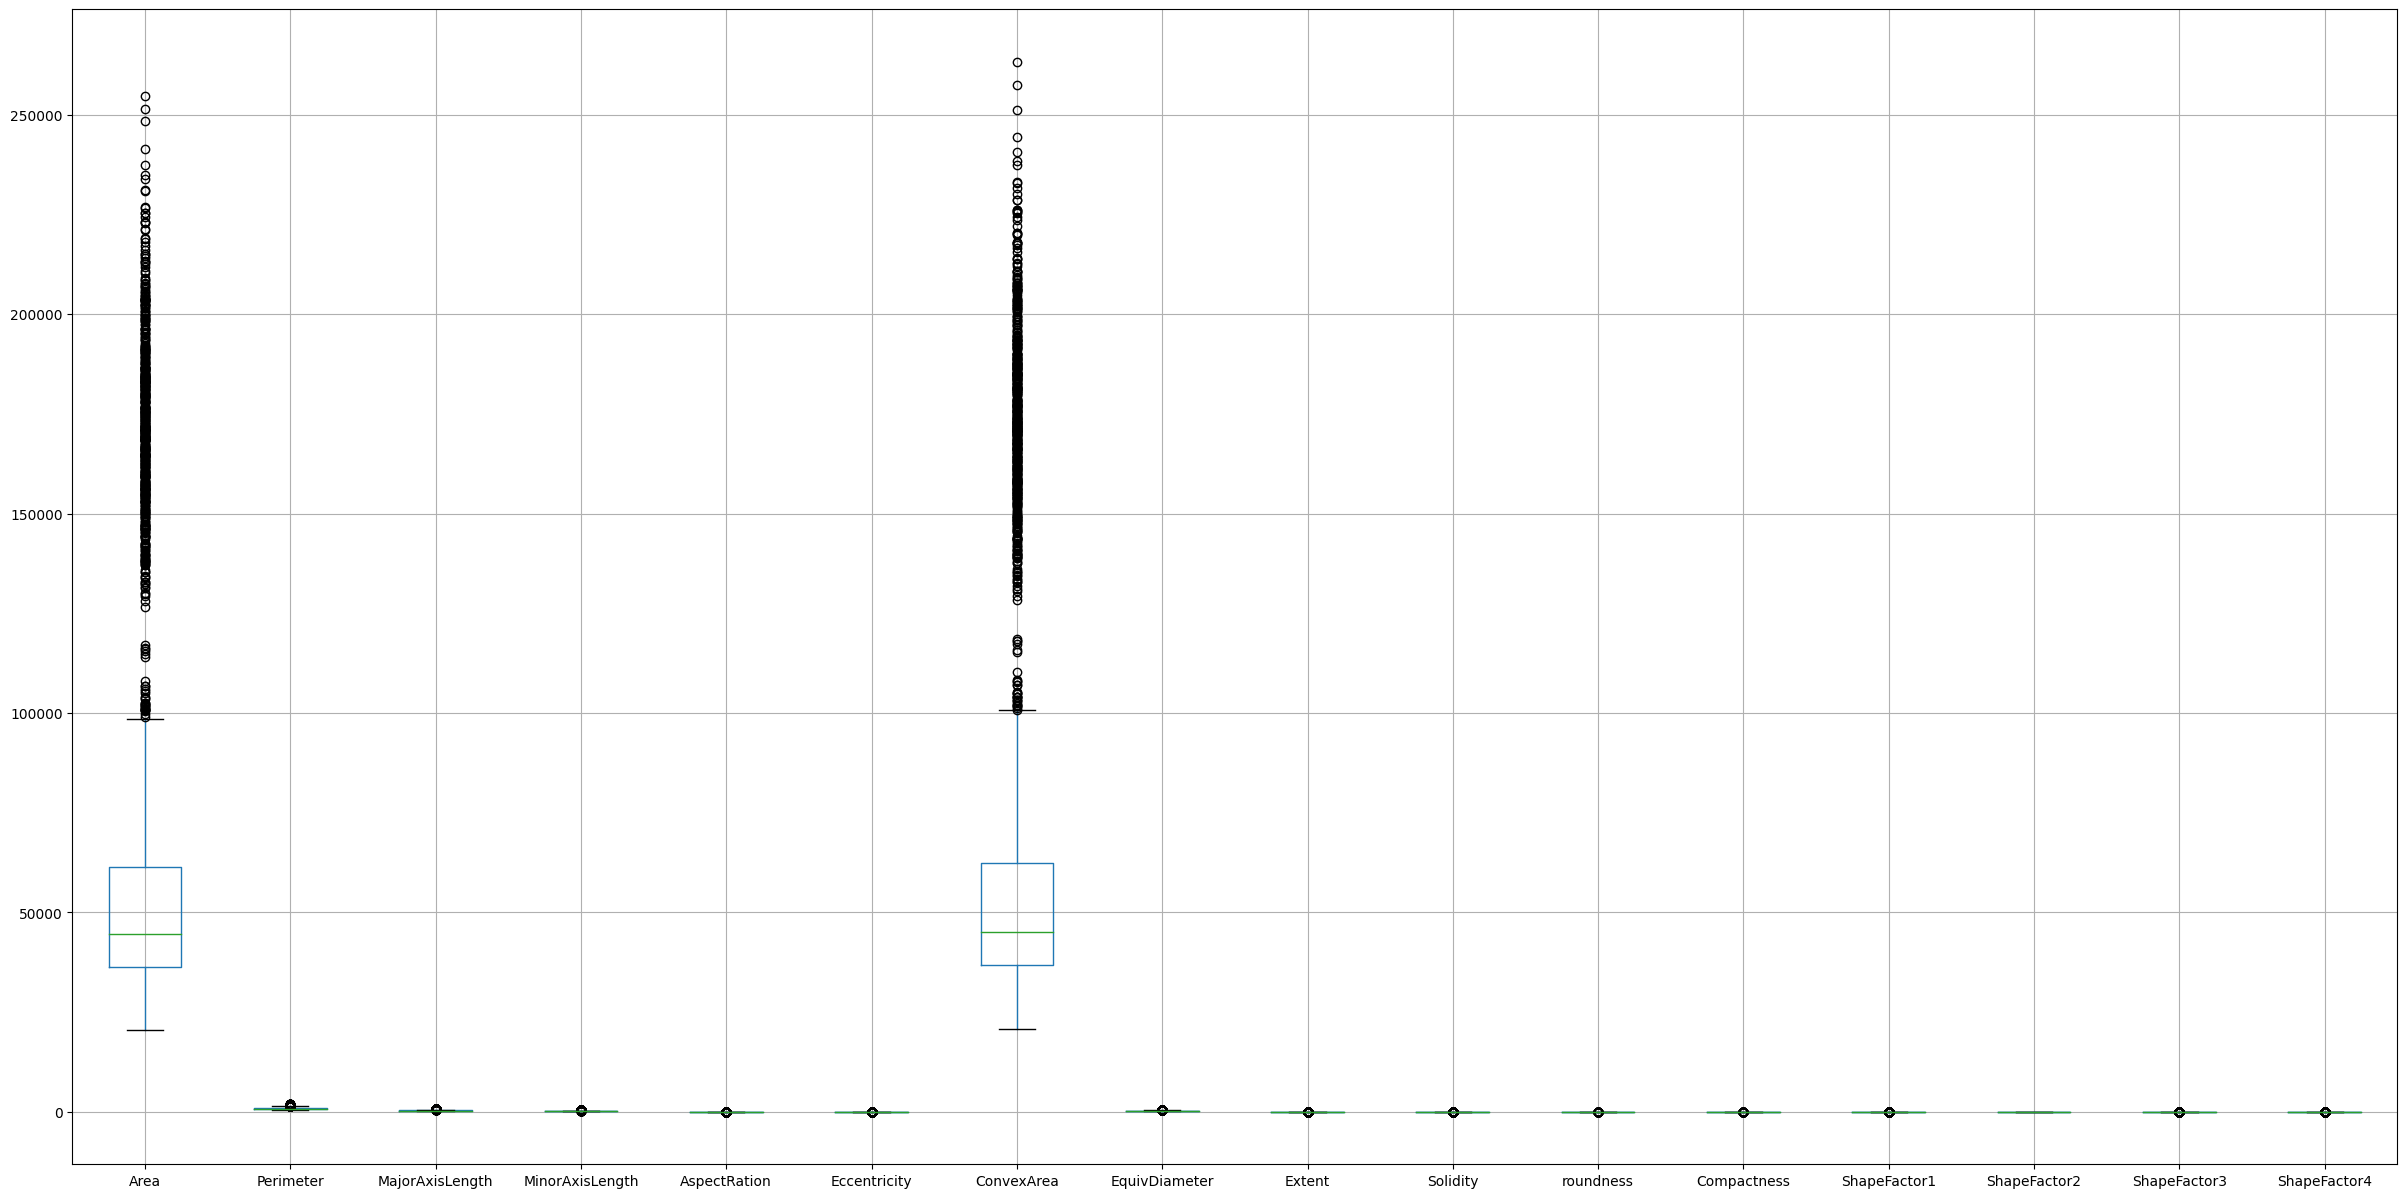

In [213]:
df[features].boxplot(figsize=(30, 15))
plt.show()

### Here, the scale differences are even more visible. Boxplots for features, excluding "Area" and "ConvexArea", are very illegible.
### An additional observation is the presence of a considerable number of outliers in both "Area" and "ConvexArea." Furthermore, outliers are noticeable in the other features as indicated by the presence of black dots. We can inspect those outliers by creating a separate boxplot for each feature

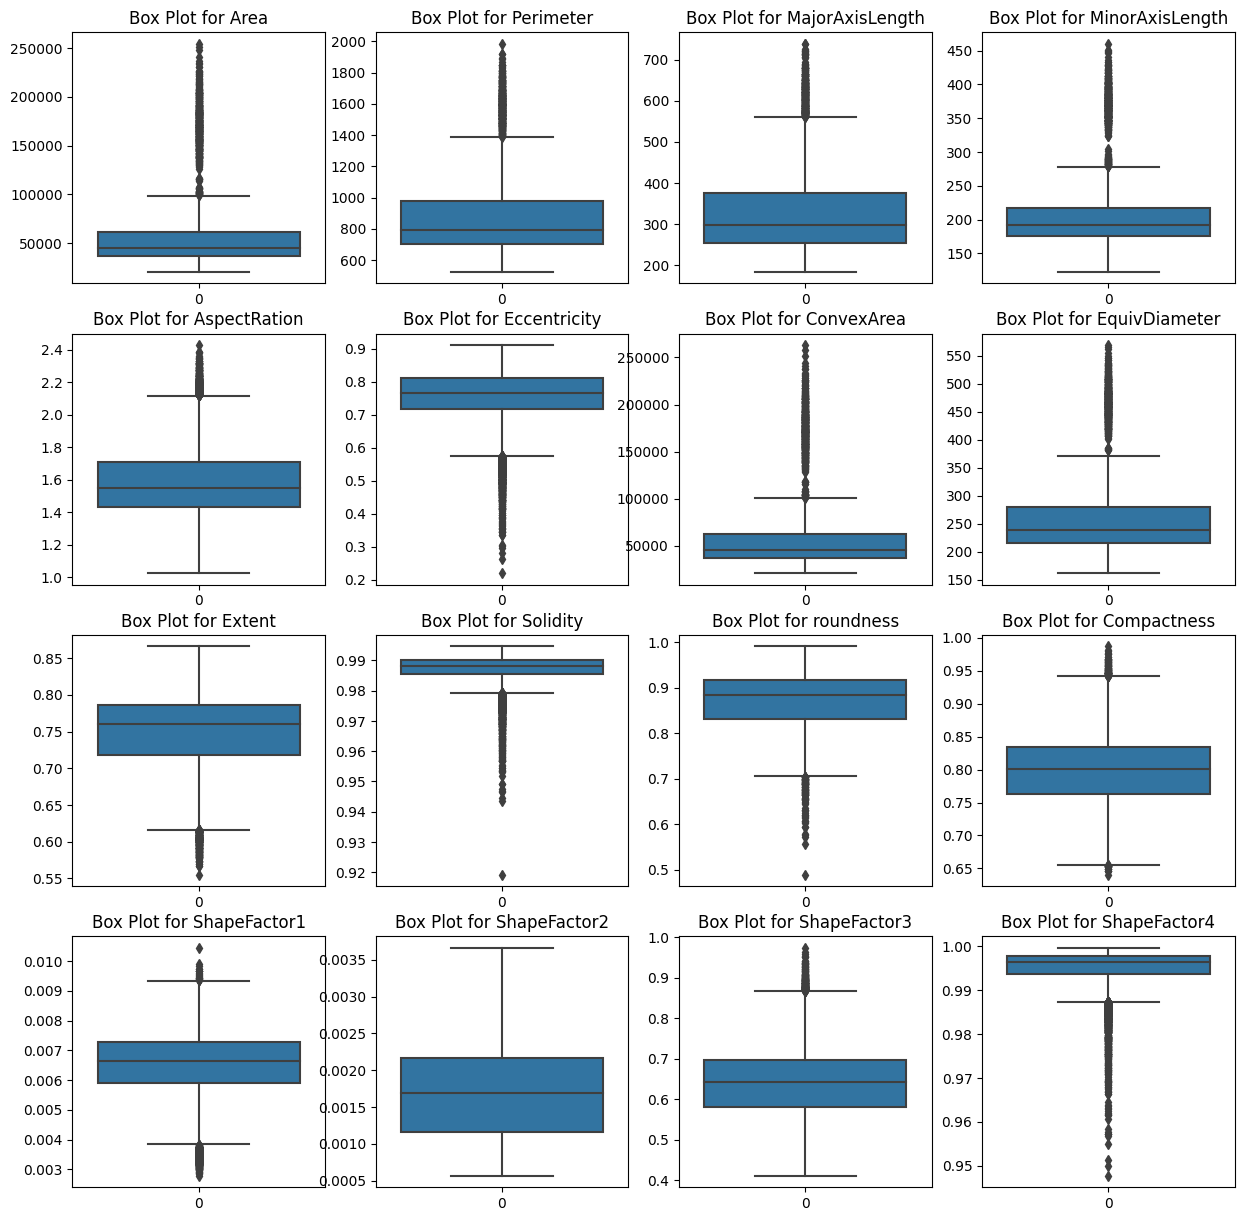

In [214]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, feature in enumerate(df[features].columns):
    sns.boxplot(df[feature],  ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Box Plot for {feature}')

### It becomes evident that the majority of our features exhibit a notable presence of outliers, with the exception of 'ShapeFactor2. This requires closer examination, as the presence of the outliers may be due to noisy data, but it's also possible that some dry beans significantly vary from the others. To inspect that even more, we can create boxplot for each type of bean

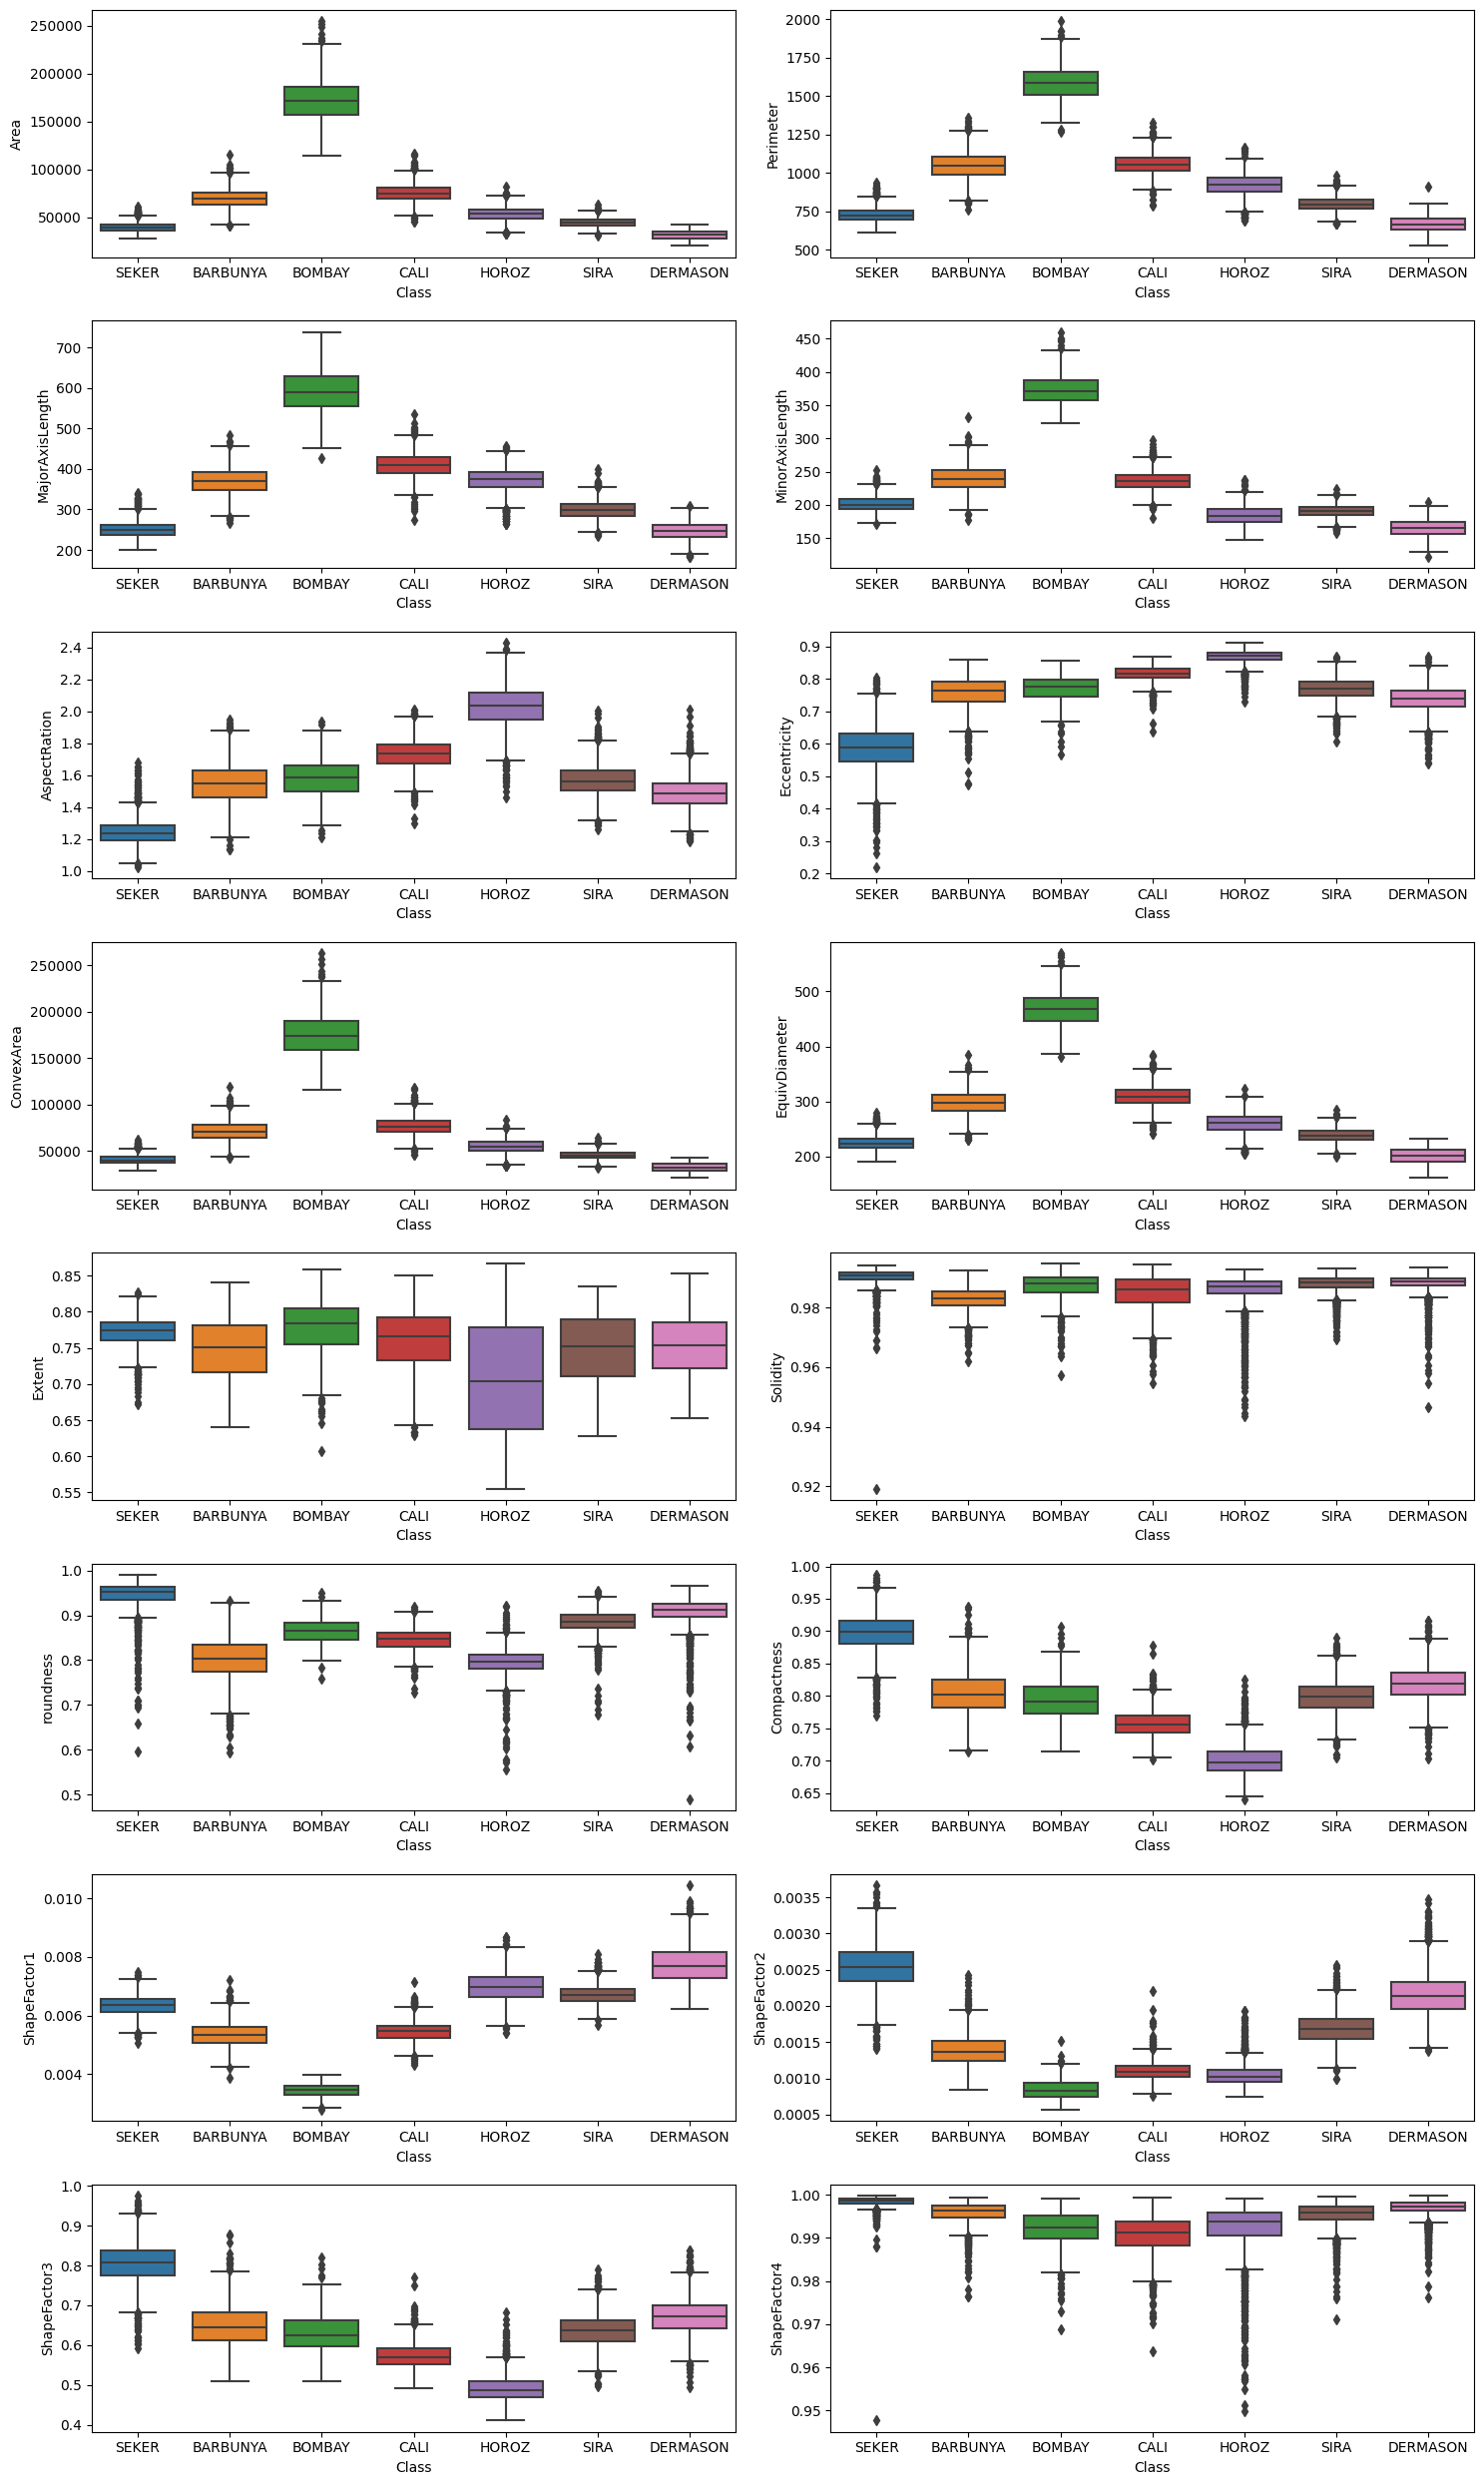

In [215]:
fig, ax = plt.subplots(8, 2, figsize=(15, 25))

for variable, subplot in zip(df[features].columns, ax.flatten()):
    sns.boxplot(x=df[target], y= df[variable], ax=subplot)
plt.tight_layout()

### We can notice that BOMBAY and HOROZ seeds stand out from other bean types, thus they may be the cause of most outliers

###Feature correlation

### To see which features are correlated the most with our target value, we will encode the target variable now

### I'm employing the Label Encoder to encode the target column. Although Label Encoder is commonly used with ordinal categorical data, it makes more sense for our task. If we were to use One-Hot Encoder, it would create a separate column for each target category, leading to increased dataset dimensionality and task complexity.

In [216]:
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

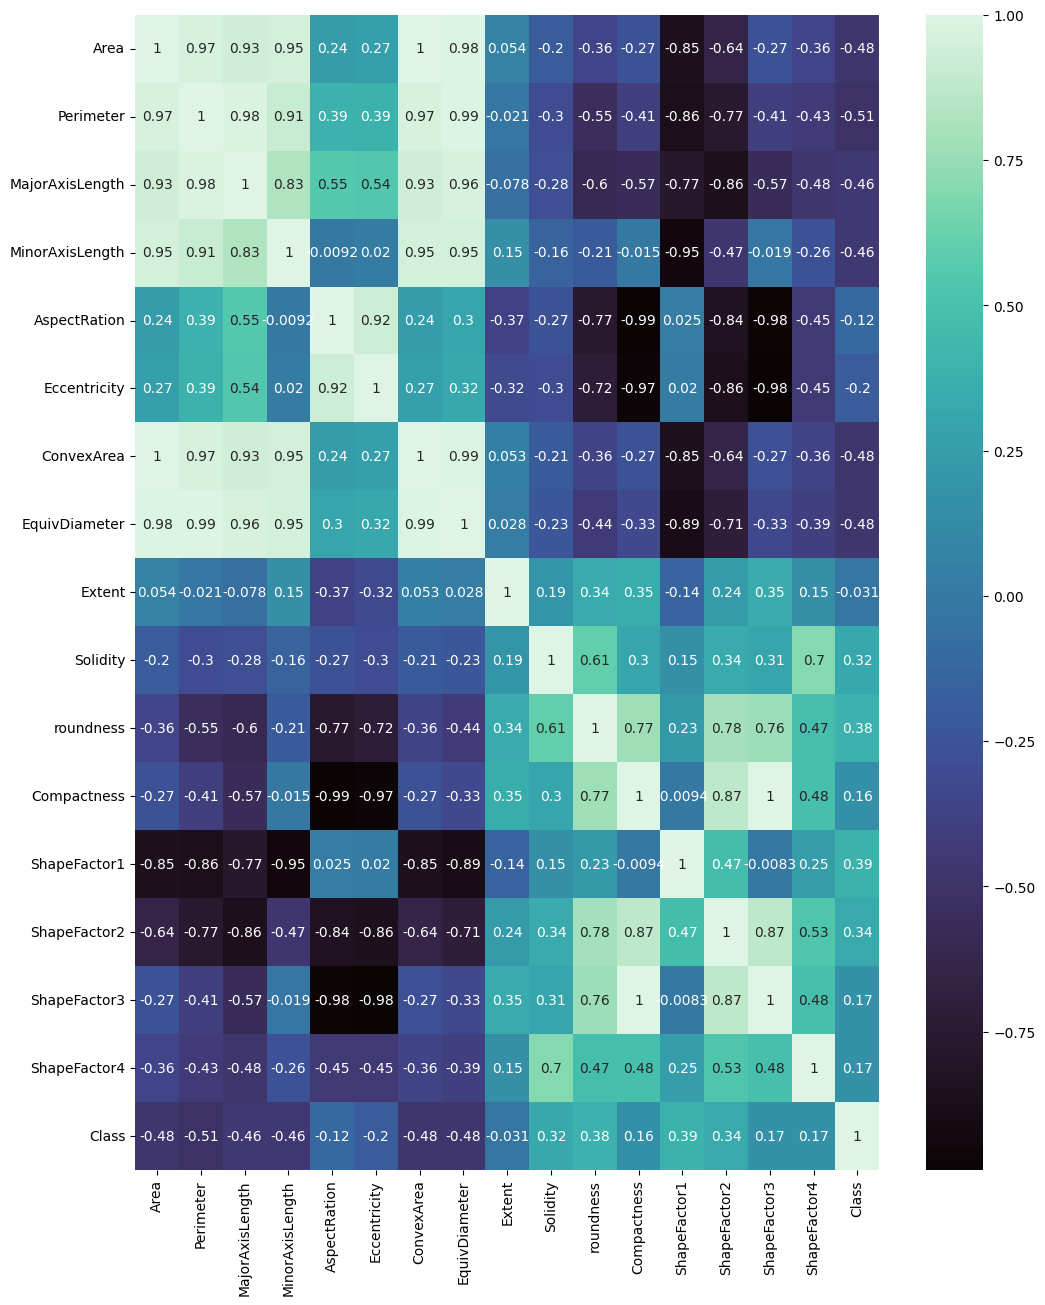

In [217]:
plt.figure(figsize=(12, 15))

sns.heatmap(df.corr(), annot=True, linecolor='black', cmap="mako")
plt.show()

### We have a lot of highly correlated features! This is due to the fact that basically all of them are kind of geometric measures. Highly correlated features essentially provide redundant information. Keeping both features doesn't contribute significantly to the model's understanding but may introduce multicollinearity issues

### While 'Perimeter' displays strong correlations with other features in the dataset, it is notably the most correlated feature with our target variable. This correlation indicates that 'Perimeter' holds important predictive potential for our target

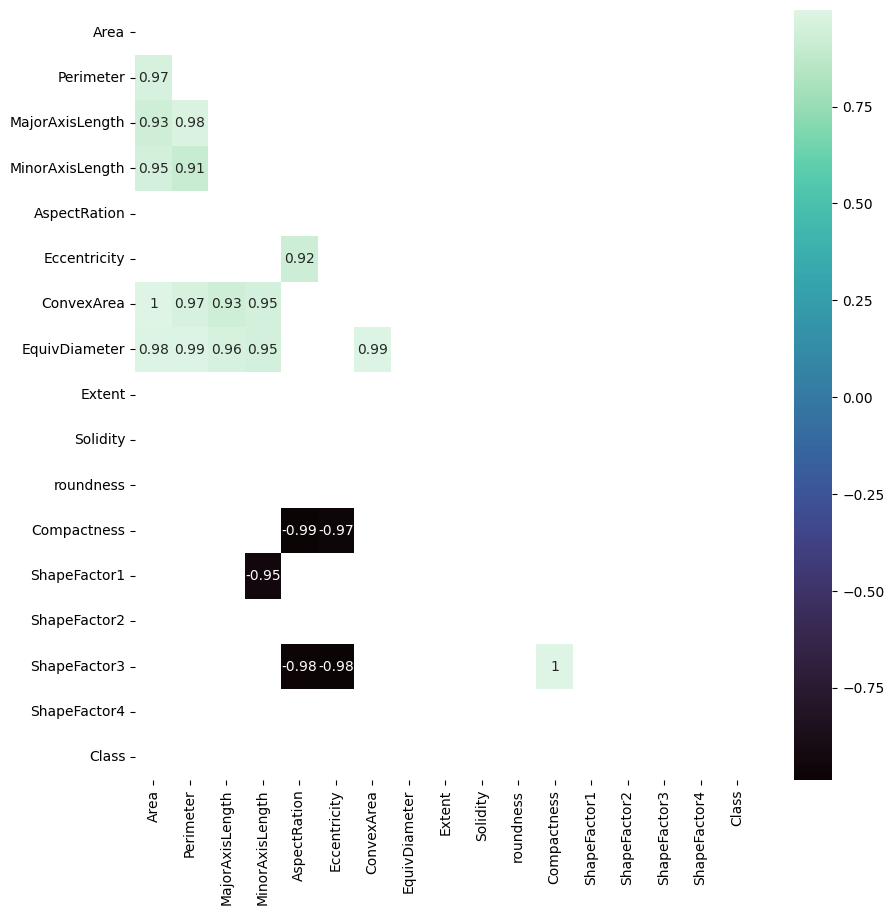

In [218]:
# Visualizing the most correlated features
plt.figure(figsize=(10, 10))

# Visualizing only the lower traingle of our feature matrix, without the diagonal as it contains only "1"
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
high_correlation_mask = (df.corr() >= 0.9) | (df.corr() <= -0.9)
tri_df = df.corr().mask(mask).where(high_correlation_mask)
sns.heatmap(tri_df, annot=True, cmap='mako')
plt.show()


In [219]:
# I've set a correlation threshold of 0.9 (and -0.9) to identify features with strong positive or negative correlations
threshold = 0.9

In [220]:
columns_to_drop = [column for column in tri_df.columns if any(tri_df[column] >= threshold) or any(tri_df[column] <= -threshold)]
columns_to_drop

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'Compactness']

### Excluding "Perimeter" from this list as it has the highest correlation with our target

In [221]:
columns_to_drop = [feature for feature in columns_to_drop if feature != 'Perimeter']
columns_to_drop

['Area',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'Compactness']

In [222]:
features = df.columns[~df.columns.isin(columns_to_drop)].tolist()
df = df.drop(columns_to_drop, axis=1)

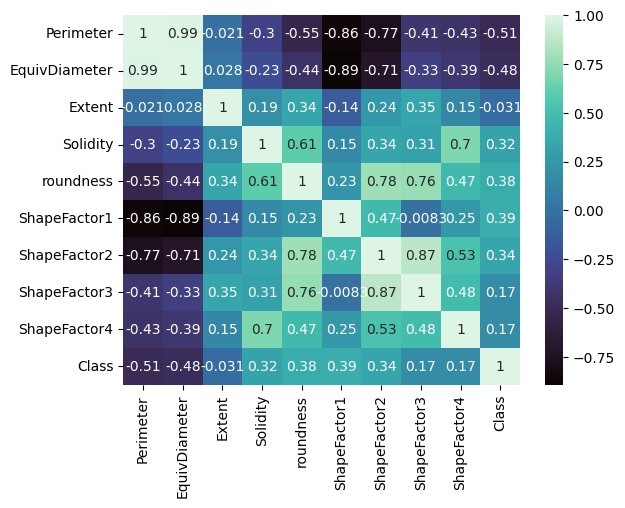

In [223]:
sns.heatmap(df.corr(), annot=True, cmap='mako')
plt.show()

##**Preprocessing**

In [224]:
# Dropping duplicates

df = df.drop_duplicates()
df.shape


(13543, 10)

### Before performing any further preprocessing steps, our dataset should be splitted into train and test sets to avoid data leakage

In [225]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df.drop("Class", axis=1), df["Class"], test_size = 0.25, random_state = 42)

**Balancing our target**

### As I mentioned before, our target class is imbalanced. An imbalanced target class in a machine learning dataset can pose challenges and introduce biases that affect the model's performance. We can try to balance the target class using SMOTE


In [226]:
# applying SMOTE only to the training set ensures that the test set remains a true representation of unseen data

oversample = SMOTE(random_state=15)
X_train, y_train = oversample.fit_resample(X_train, y_train)

### Now we need to standardize our features

In [227]:
standard_scaler = StandardScaler()
train_scaled_features = standard_scaler.fit_transform(X_train)
test_scaled_features = standard_scaler.transform(X_test)

##**ML models**

###I want to compare the performance of several machine learning models to determine which one is most effective for the given task
### Hyperparameter tuning will be performed for each model to identify the optimal set of parameters. For Logistic Regression I chose Grid Search CV, but for more complex models I've opted for Randomized Search CV as it offers better computational efficiency. Using Randomized Search CV significantly reduces the time needed for hyperparameter tuning; however, there is a potential risk that the optimal set of parameters may not be discovered, since it doesn't check every potential combination. Nevertheless, it often yields a good hyperparameter set within a reasonable timeframe.

###**1. Logistic Regression**

### When dealing with multi-class classification problems, Scikit-learn's LogisticRegression provides flexibility through the multi_class parameter. This parameter allows you to specify the strategy, offering a choice between "multinomial" and "ovr" (one-vs-rest).

###In the multinomial strategy, one model is trained to handle all classes concurrently. On the other hand, the one-vs-rest strategy involves training individual binary logistic regression models for each class

**One vs Rest**

In [228]:
param_grid = {
    "penalty" : ["l1", "l2"],
    "C" : [0.001, 0.01, 0.1, 1, 10]
}
logistic_regression = LogisticRegression(multi_class= "ovr", solver = "liblinear")  # ‘liblinear’ is limited to one-versus-rest schemes

grid_search_lr_ovr = GridSearchCV(logistic_regression, param_grid)

In [229]:
grid_search_lr_ovr.fit(train_scaled_features, y_train)

GridSearchCV(estimator=LogisticRegression(multi_class='ovr',
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']})

In [230]:
grid_search_lr_ovr.best_params_

{'C': 10, 'penalty': 'l1'}

In [231]:
y_pred_lr_ovr = grid_search_lr_ovr.predict(test_scaled_features)

### For the evaluation of model's performance accuracy and F1 score will be used as primary metrics. Furthermore, a confusion matrix will be utilized for visualization purposes.
### -> F1 score combines precision and recall using their harmonic mean, and maximizing the F1 score implies simultaneously maximizing both precision and recall

In [232]:
def metrics(predictions):

  # ACCURACY
  print("Accuracy: ", accuracy_score(y_test, predictions))
  print("\n")

  # CONFUSION MATRIX
  sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = ".0f", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="mako")
  plt.title("Confusion Matrix")
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.show()

  # F1 SCORE
  print("\n")
  f1_per_class = f1_score(y_test, predictions, average=None)
  print("Overall f1 score: ",  f1_per_class.mean())

  for i, f1 in enumerate(f1_per_class):
      print(f'F1 score for class {label_encoder.classes_[i]}: {f1:.2f}')

Accuracy:  0.9143532191376255




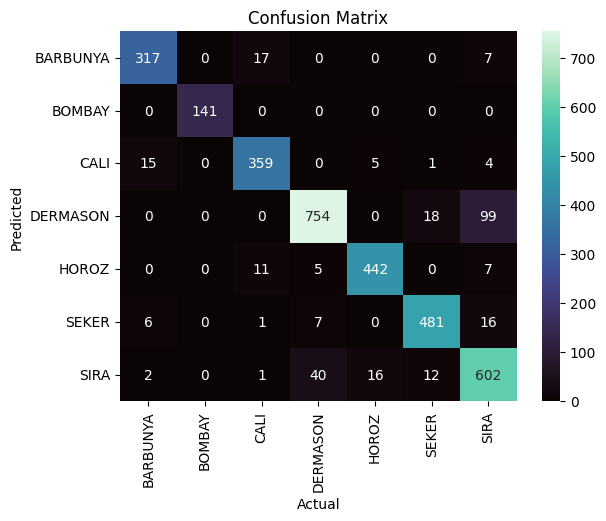



Overall f1 score:  0.9295897992716459
F1 score for class BARBUNYA: 0.93
F1 score for class BOMBAY: 1.00
F1 score for class CALI: 0.93
F1 score for class DERMASON: 0.90
F1 score for class HOROZ: 0.95
F1 score for class SEKER: 0.94
F1 score for class SIRA: 0.86


In [233]:
metrics(y_pred_lr_ovr)

### We can see that BOMBAY seeds are the easiest to distinguish, while SIRA and DERMASON are the most similar to each other

**Multinomial**

In [234]:
param_grid = {
    "solver" : ["lbfgs", "sag", "saga", "newton-cg"],
    "penalty" : ["l1", "l2", "elasticnet"],
    "C" : [0.001, 0.01, 0.1, 1, 10]
}
logistic_regression = LogisticRegression(multi_class= "multinomial")

grid_search_lr_multinomial = GridSearchCV(logistic_regression, param_grid)

In [235]:
grid_search_lr_multinomial.fit(train_scaled_features, y_train)

GridSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']})

In [236]:
grid_search_lr_multinomial.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

In [237]:
y_pred_lr_multinomial = grid_search_lr_multinomial.predict(test_scaled_features)

Accuracy:  0.9108092144122859




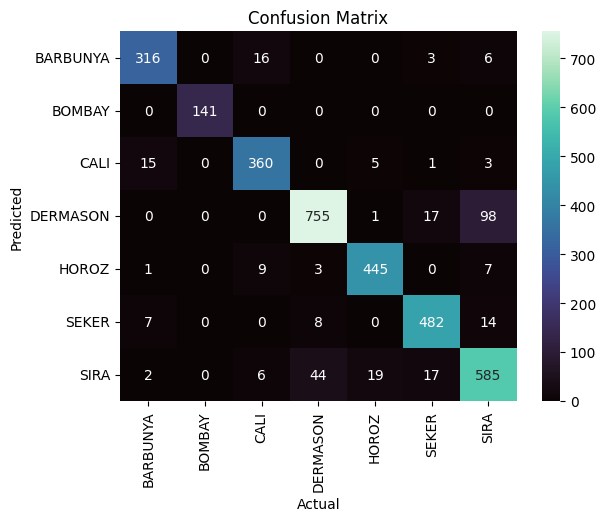



Overall f1 score:  0.9264336231959487
F1 score for class BARBUNYA: 0.93
F1 score for class BOMBAY: 1.00
F1 score for class CALI: 0.93
F1 score for class DERMASON: 0.90
F1 score for class HOROZ: 0.95
F1 score for class SEKER: 0.94
F1 score for class SIRA: 0.84


In [238]:
metrics(y_pred_lr_multinomial)

### **2. SVM**

### SVM doesn’t support multiclass classification natively. It supports binary classification and separating data points into two classes. For multiclass classification, the same principle is utilized after breaking down the multiclassification problem into multiple binary classification problems

In [239]:
param_grid = {
    "kernel" : ['rbf', 'sigmoid'],
    "C" : [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma" : [0.001, 0.01, 0.1, 1]
}

svm = SVC()

# n_iter controls the number of random combinations of hyperparameter values that will be tried during the search
random_search_svm = RandomizedSearchCV(svm, param_grid, n_iter = 20, verbose = 2)

In [240]:
random_search_svm.fit(train_scaled_features, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  26.3s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  26.2s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  27.1s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  26.5s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  26.5s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=  24.8s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=  23.1s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=  24.6s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=  24.7s
[CV] END .......................C=0.001, gamma=1, kernel=rbf; total time=  24.9s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  14.6s
[CV] END .....................C=0.1, gamma=0.00

RandomizedSearchCV(estimator=SVC(), n_iter=20,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'gamma': [0.001, 0.01, 0.1, 1],
                                        'kernel': ['rbf', 'sigmoid']},
                   verbose=2)

In [241]:
random_search_svm.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [242]:
y_pred_svm = random_search_svm.predict(test_scaled_features)

Accuracy:  0.9235085646780863




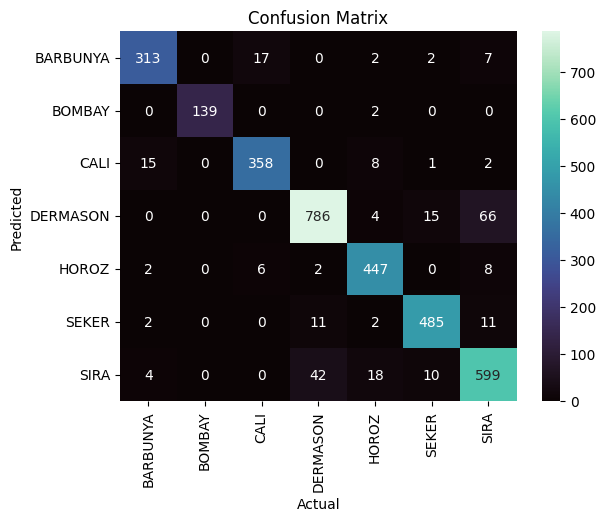



Overall f1 score:  0.9341447975124639
F1 score for class BARBUNYA: 0.92
F1 score for class BOMBAY: 0.99
F1 score for class CALI: 0.94
F1 score for class DERMASON: 0.92
F1 score for class HOROZ: 0.94
F1 score for class SEKER: 0.95
F1 score for class SIRA: 0.88


In [243]:
metrics(y_pred_svm)

###**3. Decision Tree**

### In the context of decision trees, each leaf node represents a class, and the decision tree algorithm makes decisions by traversing the tree from the root to a leaf. Decision trees work well without the need for data standardization. Hence, we will use the dataset in its original, non-standardized form

In [281]:
param_grid = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "min_samples_leaf" : [2, 4, 6, 8],
    "max_depth" : [6, 8, 10, 12],
    "max_features" : ["auto", "sqrt", "log2"],
}

decision_tree = DecisionTreeClassifier()

random_search_dt = RandomizedSearchCV(decision_tree, param_grid, n_iter=50, verbose = 2)


In [282]:
random_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6; total time=   0.1s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6; total time=   0.1s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6; total time=   0.1s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6; total time=   0.1s
[CV] END criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6; total time=   0.2s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min_samples_leaf=2; total time=   0.1s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min_samples_leaf=2; total time=   0.1s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min_samples_leaf=2; total time=   0.2s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min_samples_leaf=2; total time=   0.4s
[CV] END criterion=log_loss, max_depth=6, m

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [6, 8, 10, 12],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 4, 6, 8]},
                   verbose=2)

In [283]:
random_search_dt.best_params_

{'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini'}

In [284]:
y_pred_dt = random_search_dt.predict(X_test)

Accuracy:  0.896928529238039




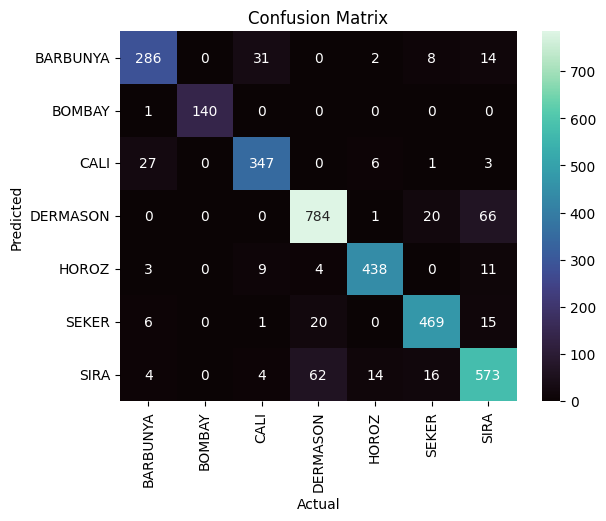



Overall f1 score:  0.90779616463241
F1 score for class BARBUNYA: 0.86
F1 score for class BOMBAY: 1.00
F1 score for class CALI: 0.89
F1 score for class DERMASON: 0.90
F1 score for class HOROZ: 0.95
F1 score for class SEKER: 0.92
F1 score for class SIRA: 0.85


In [285]:
metrics(y_pred_dt)

### **4. XGBooster**

###XGBoost is an ensemble learning algorithm based on decision trees. It builds a collection of trees iteratively, and each tree corrects errors made by the previous ones, resulting in a strong predictive model

### We can assume that XGB will outperform Decision Tree, as it combines the predictions of multiple individual trees

In [287]:
param_grid = {
    "booster" : ["gbtree", "dart"],
    "eta" : [0.01, 0.1, 0.3],
    "gamma" : [ 0, 0.1, 0.5 ],
    "max_depth" : [4, 6, 8],
    "colsample_bytree" : [0.5 , 0.8, 0.9],
}

xgb_model = xgb.XGBClassifier(objective="multi:softmax", n_estimators=100)

random_search_xgb = RandomizedSearchCV(xgb_model, param_grid, n_iter = 30, verbose = 2, cv = 2)

In [288]:
random_search_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] END booster=gbtree, colsample_bytree=0.8, eta=0.01, gamma=0.5, max_depth=4; total time=   1.0s
[CV] END booster=gbtree, colsample_bytree=0.8, eta=0.01, gamma=0.5, max_depth=4; total time=   1.0s
[CV] END booster=gbtree, colsample_bytree=0.5, eta=0.3, gamma=0, max_depth=4; total time=   0.8s
[CV] END booster=gbtree, colsample_bytree=0.5, eta=0.3, gamma=0, max_depth=4; total time=   0.8s
[CV] END booster=dart, colsample_bytree=0.9, eta=0.1, gamma=0.1, max_depth=8; total time= 2.0min
[CV] END booster=dart, colsample_bytree=0.9, eta=0.1, gamma=0.1, max_depth=8; total time= 1.4min
[CV] END booster=dart, colsample_bytree=0.9, eta=0.3, gamma=0.5, max_depth=8; total time=  47.5s
[CV] END booster=dart, colsample_bytree=0.9, eta=0.3, gamma=0.5, max_depth=8; total time=  49.0s
[CV] END booster=dart, colsample_bytree=0.9, eta=0.01, gamma=0, max_depth=8; total time= 1.0min
[CV] END booster=dart, colsample_bytree=0.9, eta=0.01, gamma=

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=30,
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'colsample_bytree': [0.5, 0.8, 0.9],
                                        'eta': [0.01, 0.1, 0.3],
                                        'gamma': [0, 0.1, 0.5],
                                        'max_depth': [4, 6, 8]},
                   verbose=2)

In [289]:
random_search_xgb.best_params_

{'max_depth': 8,
 'gamma': 0,
 'eta': 0.1,
 'colsample_bytree': 0.9,
 'booster': 'dart'}

In [290]:
y_pred_xgb = random_search_xgb.predict(X_test)

Accuracy:  0.9258712344949793




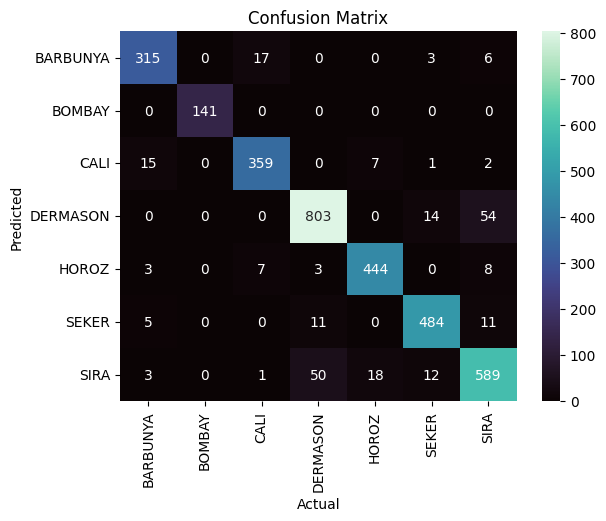



Overall f1 score:  0.9364257957448592
F1 score for class BARBUNYA: 0.92
F1 score for class BOMBAY: 1.00
F1 score for class CALI: 0.93
F1 score for class DERMASON: 0.92
F1 score for class HOROZ: 0.95
F1 score for class SEKER: 0.94
F1 score for class SIRA: 0.88


In [291]:
metrics(y_pred_xgb)

## Let's compare the models predictions

In [302]:
all_models = ["LogisticRegressionOVR", "LogisticRegressionMultinomial", "SVM", "DecisionTree", "XGBoost"]
predictions = [y_pred_lr_ovr, y_pred_lr_multinomial, y_pred_svm, y_pred_dt, y_pred_xgb]

models_and_predictions = list(zip(all_models, predictions))

In [305]:
accuracies = {}
f1_scores = {}
for model, prediction in models_and_predictions:

    accuracy = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average=None).mean()

    # Store the results in dictionaries
    accuracies[model] = accuracy
    f1_scores[model] = f1


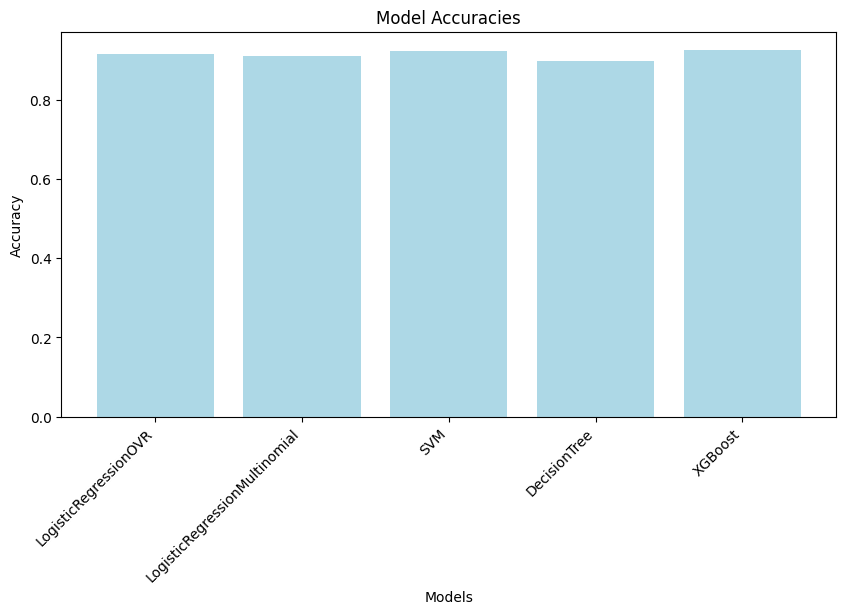

In [307]:
# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='lightblue')
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.show()

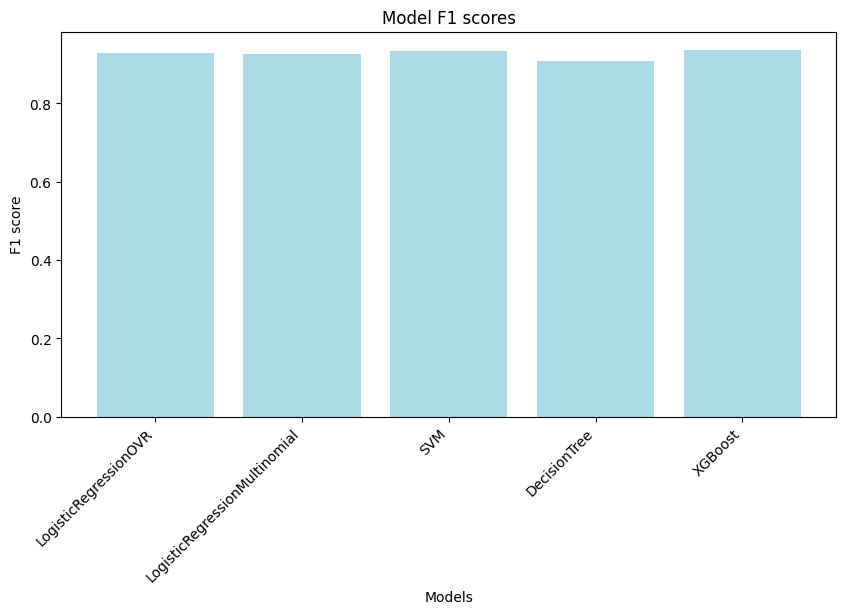

In [308]:
# Plot F1 scores
plt.figure(figsize=(10, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='lightblue')
plt.title('Model F1 scores')
plt.xlabel('Models')
plt.ylabel('F1 score')
plt.xticks(rotation=45, ha='right')
plt.show()

##We can see that SVM and XGBoost performed best on this dataset. They show only slight variations in accuracy and F1 scores, indicating comparable performance